- https://www.kaggle.com/code/ryanholbrook/seasonality
- https://www.kaggle.com/code/johnkflam/exercise-seasonality/edit
- https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e
- https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html (multi-index)
- https://github.com/jakevdp/PythonDataScienceHandbook (Python data science handbook)
- 

In [2]:
# %load ../../import_matplot.py
import pandas as pd
import jlam.eda_util as edu
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


pd.set_option('display.max_rows',500)

# global settings
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11,5))
plt.rc("axes", 
           labelweight="bold", labelsize="large",
           titleweight="bold", titlesize=14, titlepad=10
          )

In [4]:
import os
import sys
sys.path.append('../../sap/deployed_acv_vs2/dacv')

In [16]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax




In [15]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [44]:
# Constants
CRM = 'CRM_Account'

# Test Area

In [55]:
def get_booking_raw(rows_to_get=None):
    date_col='Year_Month_YYYY_MM'
    date_idx='booking_date'
    if rows_to_get is None:
        # get all
        df0=pd.read_csv('../../sap/deployed_acv_vs2/data/download_from_source/booking.csv',sep='\t'
                    ,parse_dates=[date_col]
                   ,infer_datetime_format=True
                   )
    else:
        df0=pd.read_csv('../../sap/deployed_acv_vs2/data/download_from_source/booking.csv',sep='\t',nrows=rows_to_get
                        ,parse_dates=[date_col]
                       ,infer_datetime_format=True
                       )
    df0.rename(columns={date_col:date_idx},inplace=True)
#     df0.set_index(df0[date_idx],inplace=True,drop=True)
#     df0.sort_index(inplace=True)
    df0=df0.set_index(date_idx).to_period("D")
    df0['cnt']=1
    return df0

In [111]:
def get_booking_count(df_bk_r):
    """ get booking group by count"""
    df = df_bk_r.groupby('booking_date')['cnt'].sum().reset_index()
    df.columns=['bk_dt','cnt']
    df = df.set_index('bk_dt')
    return df

In [107]:
df_bk_r = get_booking_raw(2000)
# df0.index.name,df0.index.dtype

In [113]:
df_bk_cnt = get_booking_count(df_bk_r)

In [114]:
# clone and add date elements
X = df_bk_cnt

# days within a week
X["day"] = X.index.dayofweek # the x-axis (freq)
X["week"] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='cnt'>

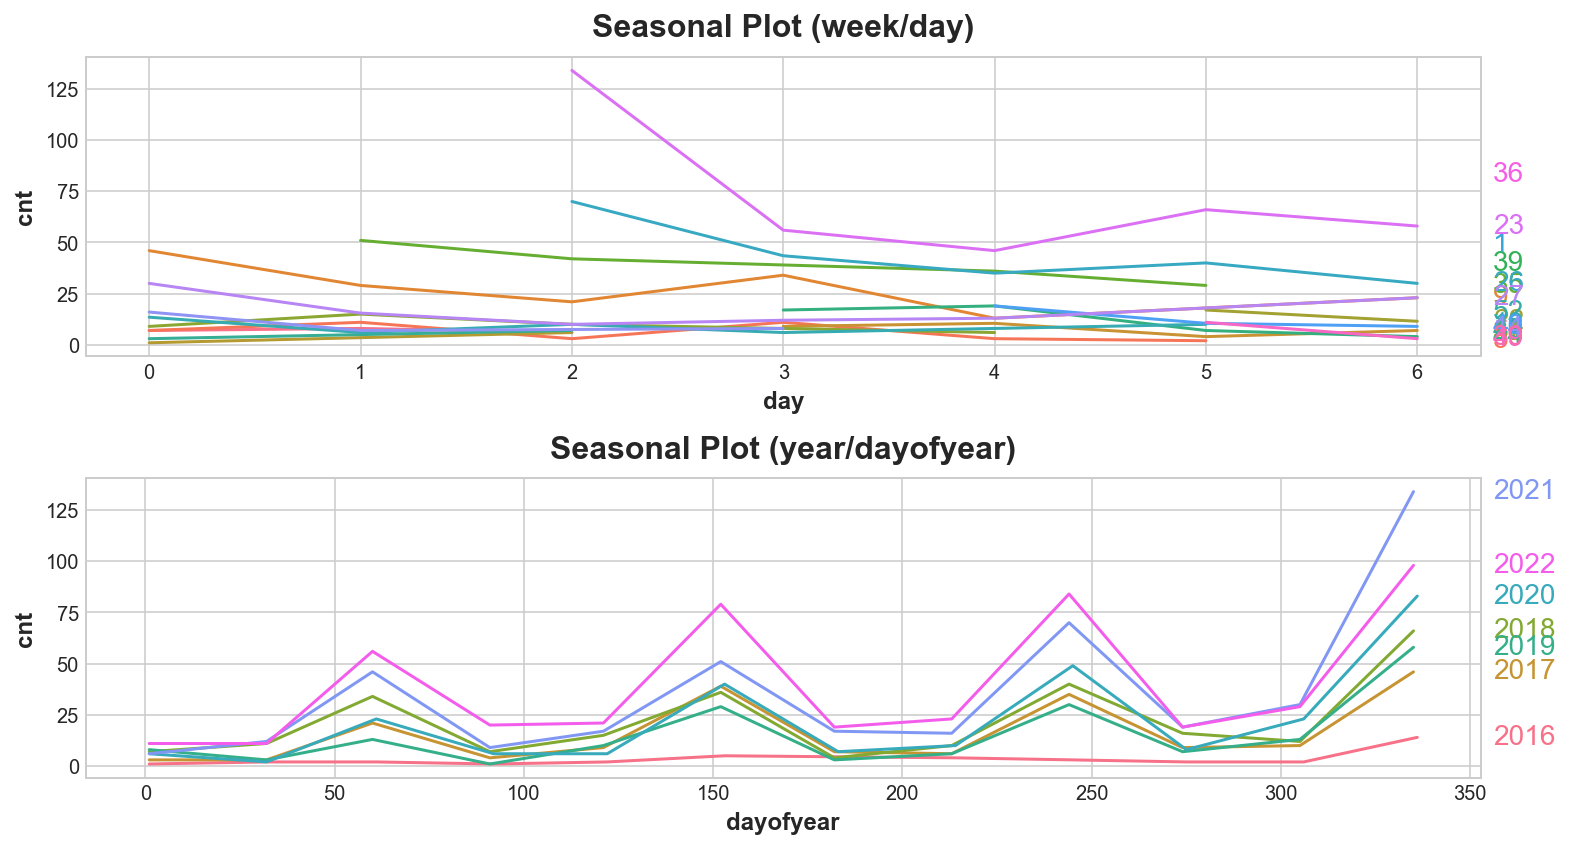

In [79]:
# plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11,6))
seasonal_plot(X, y="cnt", period="week", freq="day", ax=ax0)
seasonal_plot(X, y='cnt', period="year", freq="dayofyear", ax=ax1)

In [26]:
# df0['booking_date']=df0['Year_Month_YYYY_MM'].apply(lambda x:f'{x}-01')
# df0['booking_date']=pd.to_datetime(df0['booking_date'])

### Periodogram tells us which cycle has the strongest seasonality trend

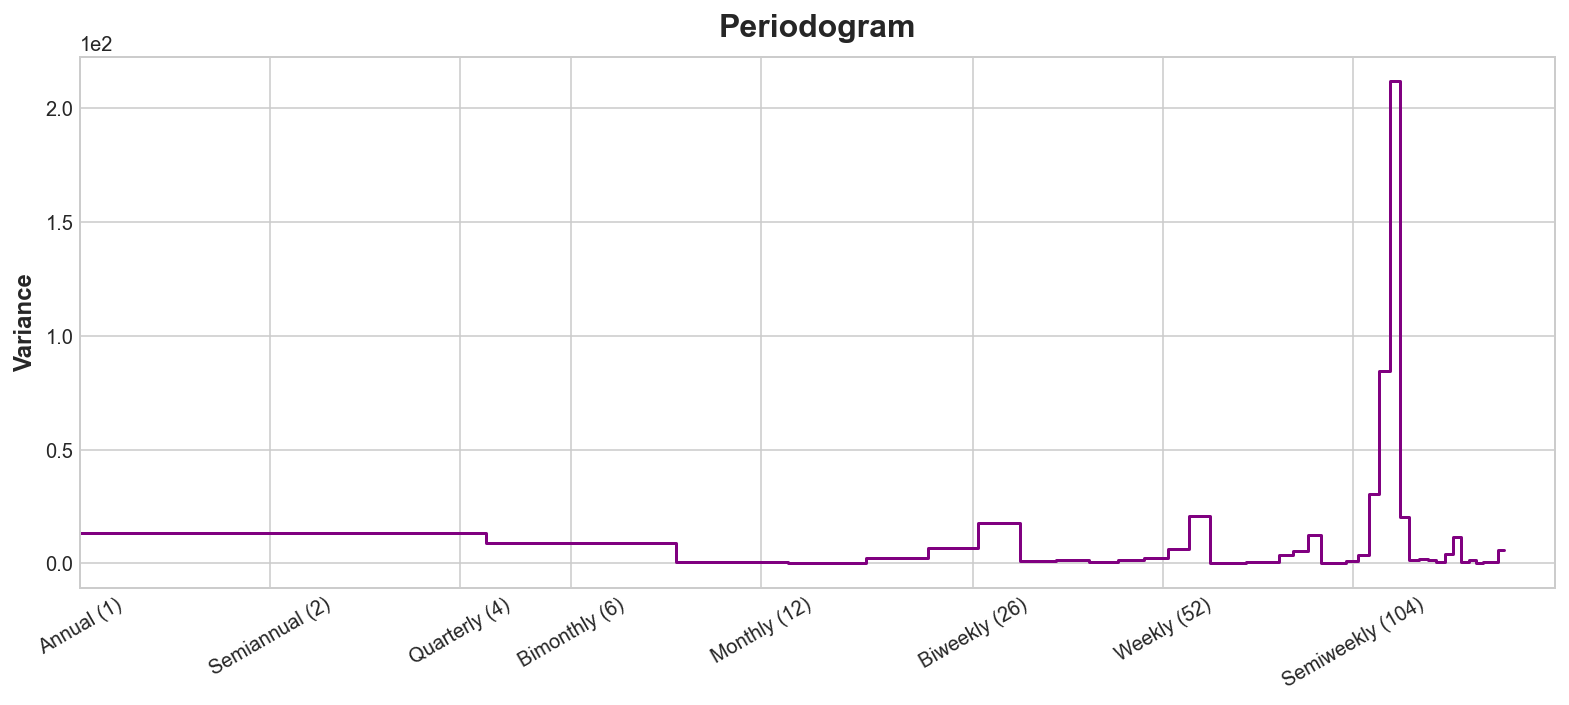

In [82]:
X = get_X()
plot_periodogram(X.cnt);

In [30]:
s_cnt=df0.resample('m')['CRM_Account'].count()

<AxesSubplot:xlabel='booking_date'>

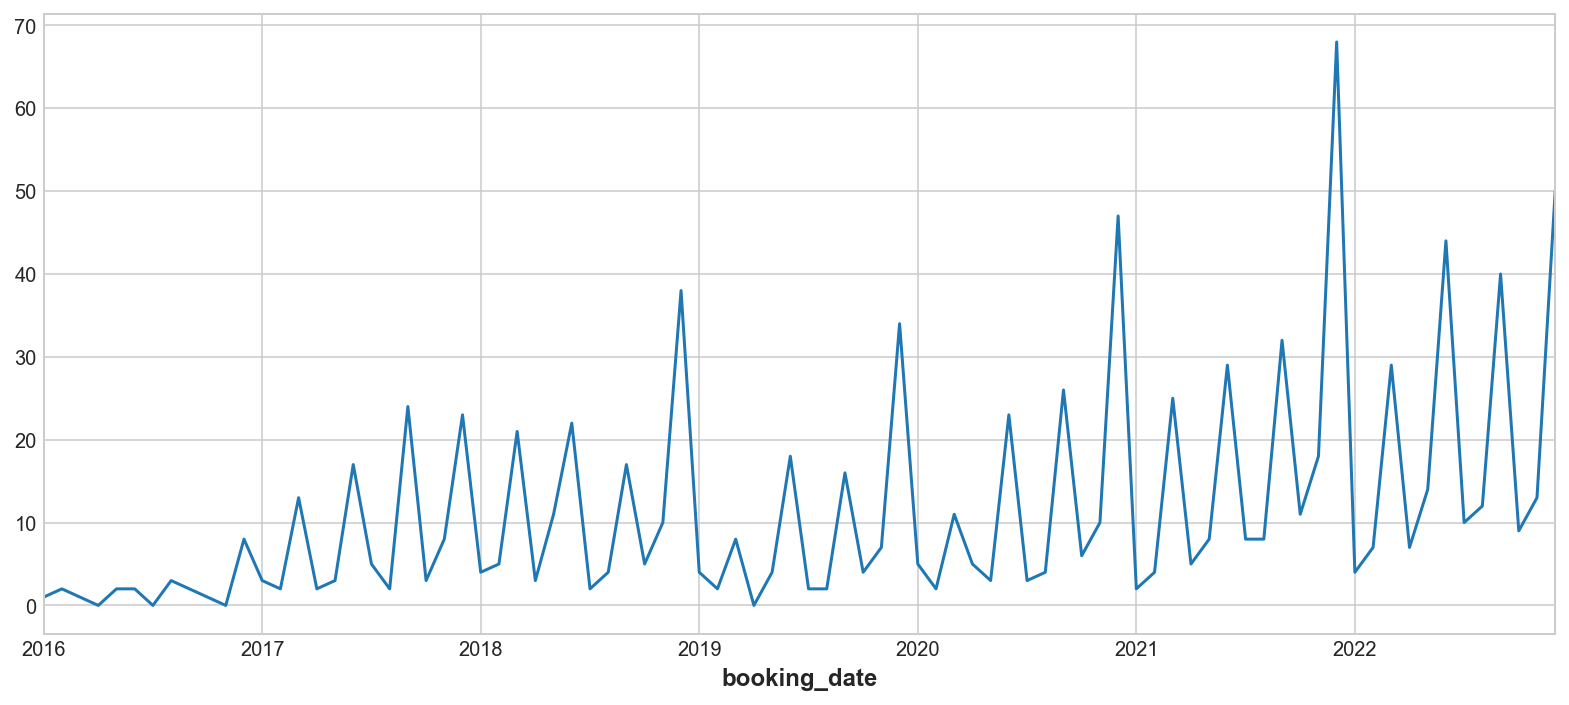

In [31]:
s_cnt.plot()

# Modeling

In [83]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [84]:
fourier = CalendarFourier(freq="A", order=10)

In [92]:
dp = DeterministicProcess(
    index=X.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

In [95]:
X.head()

,cnt
bk_dt,
2016-01-01,1
2016-02-01,2
2016-03-01,2
2016-04-01,1
2016-05-01,2


In [94]:
# get X and y
X0=dp.in_sample()
y0=X['cnt']

In [97]:
# train model
model = LinearRegression(fit_intercept=False)
_ = model.fit(X0,y0)

Checking X array...
Checking y array...


In [99]:
# predict & forecast
y_pred = pd.Series(model.predict(X0), index=y0.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

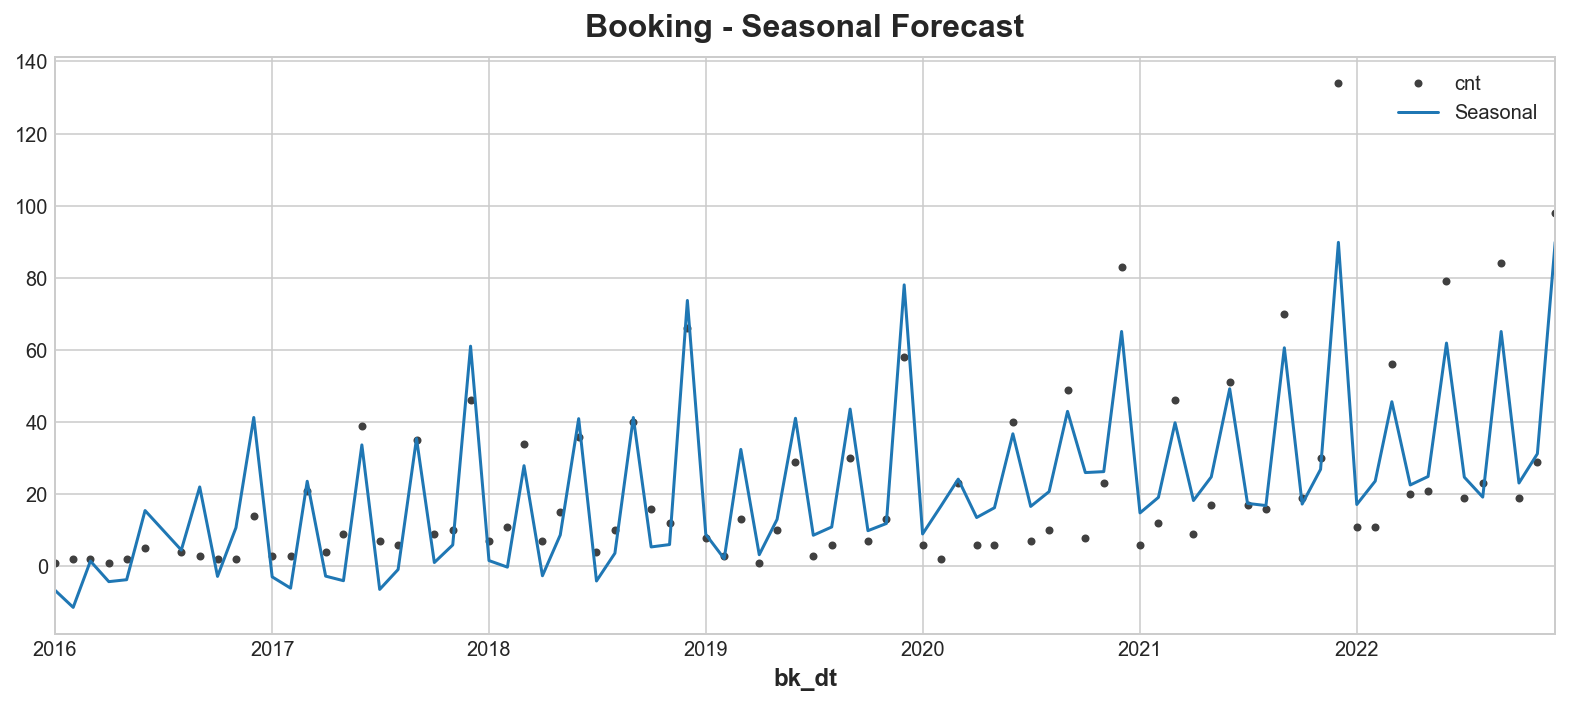

In [104]:
ax = y0.plot(color='0.25', style='.', title="Booking - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
# ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color="C3")
_ = ax.legend()

# Seasonal Decompose

In [116]:
df_bk_cnt.reset_index()

,bk_dt,cnt,day,week,dayofyear,year
0,2016-01-01,1,4,53,1,2016
1,2016-02-01,2,0,5,32,2016
2,2016-03-01,2,1,9,61,2016
3,2016-04-01,1,4,13,92,2016
4,2016-05-01,2,6,17,122,2016
5,2016-06-01,5,2,22,153,2016
6,2016-08-01,4,0,31,214,2016
7,2016-09-01,3,3,35,245,2016
8,2016-10-01,2,5,39,275,2016
9,2016-11-01,2,1,44,306,2016


In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_bk_cnt, model='multiplicative')

TypeError: PeriodIndex given. Check the `freq` attribute instead of using infer_freq.